## Import Libraries

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.patches as mpatches
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor

pd.set_option('display.max_columns', None)


## Load data

In [61]:
path = '/Users/alexaterrazas/Desktop/Lake Transfer Function Manuscript/'
df = pd.read_csv(path + 'ERA5_LakeTemp.csv')

# Subset of the data used in the analysis
df_sub = df[['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth',
             'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg',  'tas_ann_avg']]
             

df_sub

,lswt_ao_avg,abs_lat,elevation_km,log_lake_area,log_depth,tcc_ann_avg,rh_ann_avg,ssr_ann_avg,u10_ann_avg,tas_ann_avg
0,1.651429,66.045499,0.145,10.323862,4.279440,69.828000,83.100494,6855008.5,-0.772132,-6.916099
1,5.915714,61.686169,0.148,10.193702,4.079231,68.507324,82.211360,8087732.0,-0.752795,-4.109226
2,6.167143,47.404209,0.179,11.312569,4.988390,70.047005,82.009660,11453339.0,1.421462,3.403867
3,13.377143,42.800746,0.175,10.963478,4.433195,65.781070,79.898430,13610045.0,1.222900,8.354764
4,11.057143,44.756304,0.175,10.992038,4.091006,67.142430,80.979000,12723721.0,1.852352,6.322446
...,...,...,...,...,...,...,...,...,...,...
1390,34.177143,27.964728,0.350,4.593098,1.252763,30.269270,36.241375,17317706.0,-1.394071,21.850060
1391,32.702857,30.844098,0.117,4.437106,2.251292,32.712025,47.085240,17531248.0,-0.143916,19.793040
1392,22.497143,32.478639,0.060,4.464528,1.686399,33.717556,49.851850,17753004.0,0.328720,19.291960
1393,23.392857,32.418694,0.001,4.577491,3.135494,44.109386,72.814224,14977280.0,0.029541,18.569963


## Figure 2a

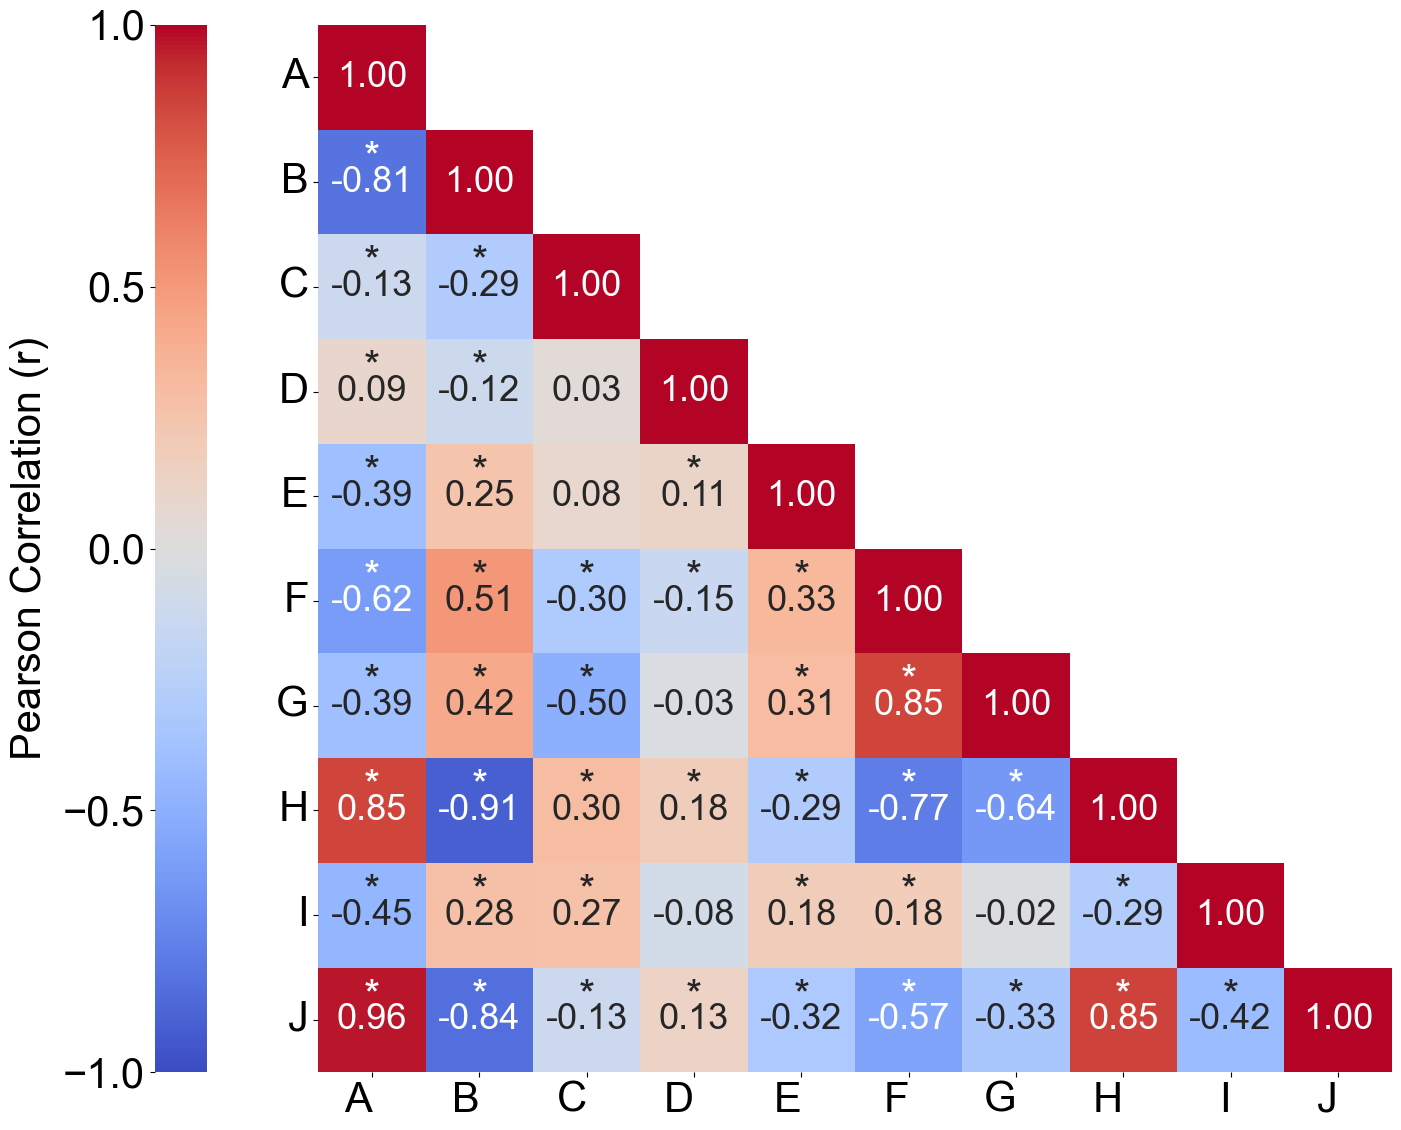

In [70]:
# Function to calculate the p-values for the correlation matrix
def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    pvalues = pd.DataFrame(data=np.zeros((df.shape[1], df.shape[1])), columns=df.columns, index=df.columns)
    for row in df.columns:
        for col in df.columns:
            pvalues[row][col] = round(pearsonr(df[row], df[col])[1], 4)
    return pvalues

df_sub = df[['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth', 
             'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg',  'tas_ann_avg']]

# Use the entire dataset
df = df_sub  # Assuming df_sub is your DataFrame

# Generate correlation matrix
correlation_matrix = df.corr()

# Calculate p-values
pvalues = calculate_pvalues(df)

# Mask the upper triangle, but keep the diagonal
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1)

# Set up the matplotlib figure
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 30
fig, ax = plt.subplots(figsize=(15, 12))

# Draw the heatmap
heatmap = sns.heatmap(correlation_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                      vmin=-1, vmax=1, center=0, annot_kws={"size": 26}, cbar_kws={'label': 'Correlation', 
                      'location': 'left', 'pad': 0.08, 'ticks': [-1, -0.5, 0, 0.5, 1]}, ax=ax)

# Customize ticks
categories = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J']
ax.set_xticklabels(categories, rotation=0, ha="right", fontsize=30)
ax.set_yticklabels(categories, rotation=0, fontsize=30)

# Add significance levels with dynamic color based on text color
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if pvalues.iloc[i, j] < 0.001:
            # Locate the correct annotation text based on its position
            for text in heatmap.texts:
                if (text.get_position() == (j + 0.5, i + 0.5)):
                    text_color = text.get_color()
                    ax.text(j + 0.5, i + 0.28, '*', ha='center', va='center', color=text_color, fontsize=30)
                    break

# Adjust colorbar label
cbar = heatmap.collections[0].colorbar
cbar.set_label('Pearson Correlation (r)', fontsize=30, labelpad=10, y=0.5)

plt.tight_layout()
# plt.savefig('fig3a_080724.png', dpi = 300)
plt.show()


## Figure 2b

In [63]:
# Assuming df_sub is your DataFrame and features are the columns to be used in PCA
features = ['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth',
             'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg']
            
X = df_sub[features]

# Standardize the data
X_standardized = (X - X.mean()) / X.std()

# Perform PCA
pca = PCA(n_components=2)
pca.fit(X_standardized)

# Get the loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Create a DataFrame for the loadings
loadings_df = pd.DataFrame(loadings, columns=['PC1', 'PC2'], index=features)
loadings_df = loadings_df.abs()  # Get absolute values

# Display explained variance
explained_variance = pca.explained_variance_ratio_
print(f'Explained variance by PC1: {explained_variance[0]*100:.2f}%')
print(f'Explained variance by PC2: {explained_variance[1]*100:.2f}%')


Explained variance by PC1: 45.47%
Explained variance by PC2: 18.39%


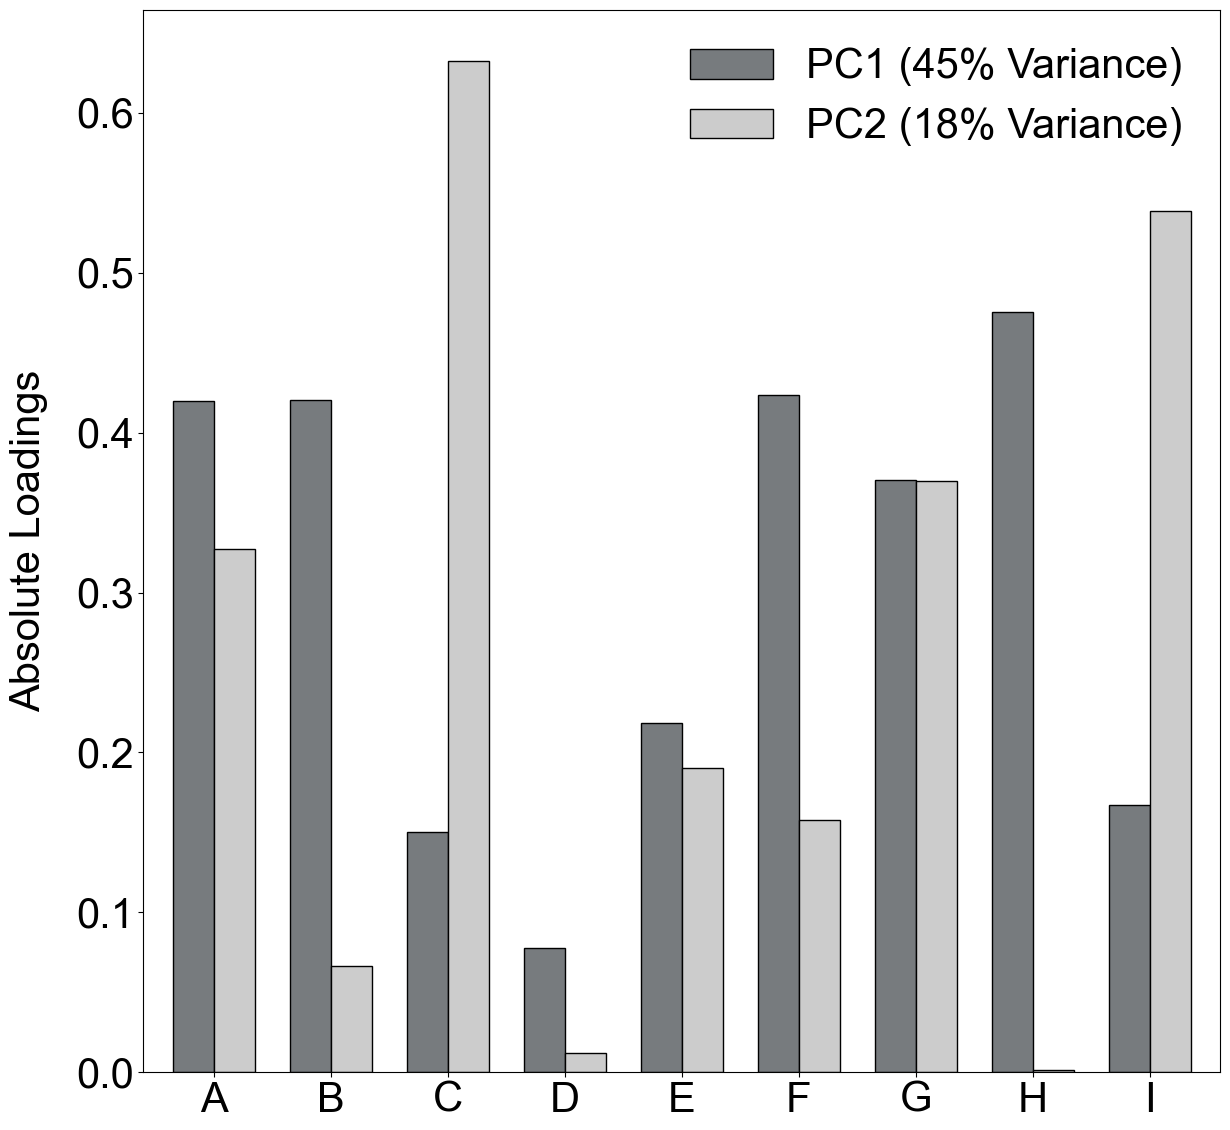

In [71]:
# Assuming you have imported your DataFrame df already

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 30

# Define the desired order of variables
desired_order = ['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth', 
             'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg']

# Select the features for the PCA analysis
features = desired_order

# Standardize the data using the StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df[features])

# Perform the PCA analysis
pca = PCA()
pca_result = pca.fit_transform(scaled_data)

# Get the absolute variable loadings for PC1 and PC2
variable_loadings = np.abs(pca.components_.T[:, :2])  # Extract only the first two PCs

# Calculate the percentage of variance explained by PC1 and PC2
explained_variance_ratio = pca.explained_variance_ratio_
variance_pc1 = explained_variance_ratio[0] * 100
variance_pc2 = explained_variance_ratio[1] * 100

# Create a DataFrame to store the results
loadings_df = pd.DataFrame(variable_loadings, columns=['PC1', 'PC2'], index=features)

# Sort the DataFrame by the absolute loading values in descending order
loadings_df = loadings_df.loc[desired_order]

# Define the shades of gray using RGB values from tab20 color palette
gray1 = '#777B7E'  # Dark gray
gray2 = (0.8, 0.8, 0.8)  # Light gray

# Custom x-axis labels
custom_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I']

# Create a figure with only one subplot
fig, axs = plt.subplots(1, 1, figsize=(13, 12))

# Plot the variable loadings with shades of gray from tab20 color palette
colors = [gray1, gray2]
ax = loadings_df.plot(kind='bar', ax=axs, color=colors, edgecolor='k', width=0.7)  # Add edgecolor='k'

# Set labels and title for the variable loadings plot
ax.set_ylabel('Absolute Loadings', labelpad=20)

# Rotate the x-axis labels at 0 degrees
ax.set_xticklabels(custom_labels, rotation=0)

# Create custom legend elements for the variable loadings plot
legend_elements = [
    mpatches.Patch(color=colors[0], label=f'PC1 ({variance_pc1:.0f}% Variance)'),
    mpatches.Patch(color=colors[1], label=f'PC2 ({variance_pc2:.0f}% Variance)')
]

# Add a legend to the variable loadings plot
ax.legend(handles=legend_elements, loc='upper right', frameon=False)
# Add an edgecolor to the legend boxes
for patch in ax.legend_.get_patches():
    patch.set_edgecolor('k')

# Display the plot
plt.tight_layout()
plt.savefig('fig3b_080724.png', dpi = 300)
plt.show()


## Figure 2c

In [65]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Your DataFrame df_sub and features
X = df_sub[['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth', 
            'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg']]


# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Iteratively remove features with the highest VIF
def remove_high_vif_features(X, threshold=10):
    while True:
        vif = calculate_vif(X)
        max_vif = vif['VIF'].max()
        if max_vif > threshold:
            max_vif_feature = vif.loc[vif['VIF'].idxmax(), 'variables']
            print(f'Removing {max_vif_feature} with VIF={max_vif}')
            X = X.drop(columns=[max_vif_feature])
        else:
            break
    # Always remove 'u10_ann_avg' at the end if it is still in the dataset
    if 'u10_ann_avg' in X.columns:
        print('Removing u10_ann_avg by request')
        X = X.drop(columns=['u10_ann_avg'])
    return X, calculate_vif(X)

# Apply the function
X_reduced, final_vif = remove_high_vif_features(X)

# Print the remaining features and their VIFs
print("Final features:\n", X_reduced.columns)
print("Final VIFs:\n", final_vif)


Removing rh_ann_avg with VIF=212.58059363076723
Removing ssr_ann_avg with VIF=61.099464135786384
Removing log_lake_area with VIF=27.899289506539954
Removing tcc_ann_avg with VIF=22.382208533904432
Removing u10_ann_avg by request
Final features:
 Index(['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_depth'], dtype='object')
Final VIFs:
       variables       VIF
0   lswt_ao_avg  1.922696
1       abs_lat  5.051826
2  elevation_km  1.286515
3     log_depth  5.963455


Removing rh_ann_avg with VIF=212.58059363076723
Removing ssr_ann_avg with VIF=61.099464135786384
Removing log_lake_area with VIF=27.899289506539954
Removing tcc_ann_avg with VIF=22.382208533904432
Removing u10_ann_avg by request
Removing log_depth by request


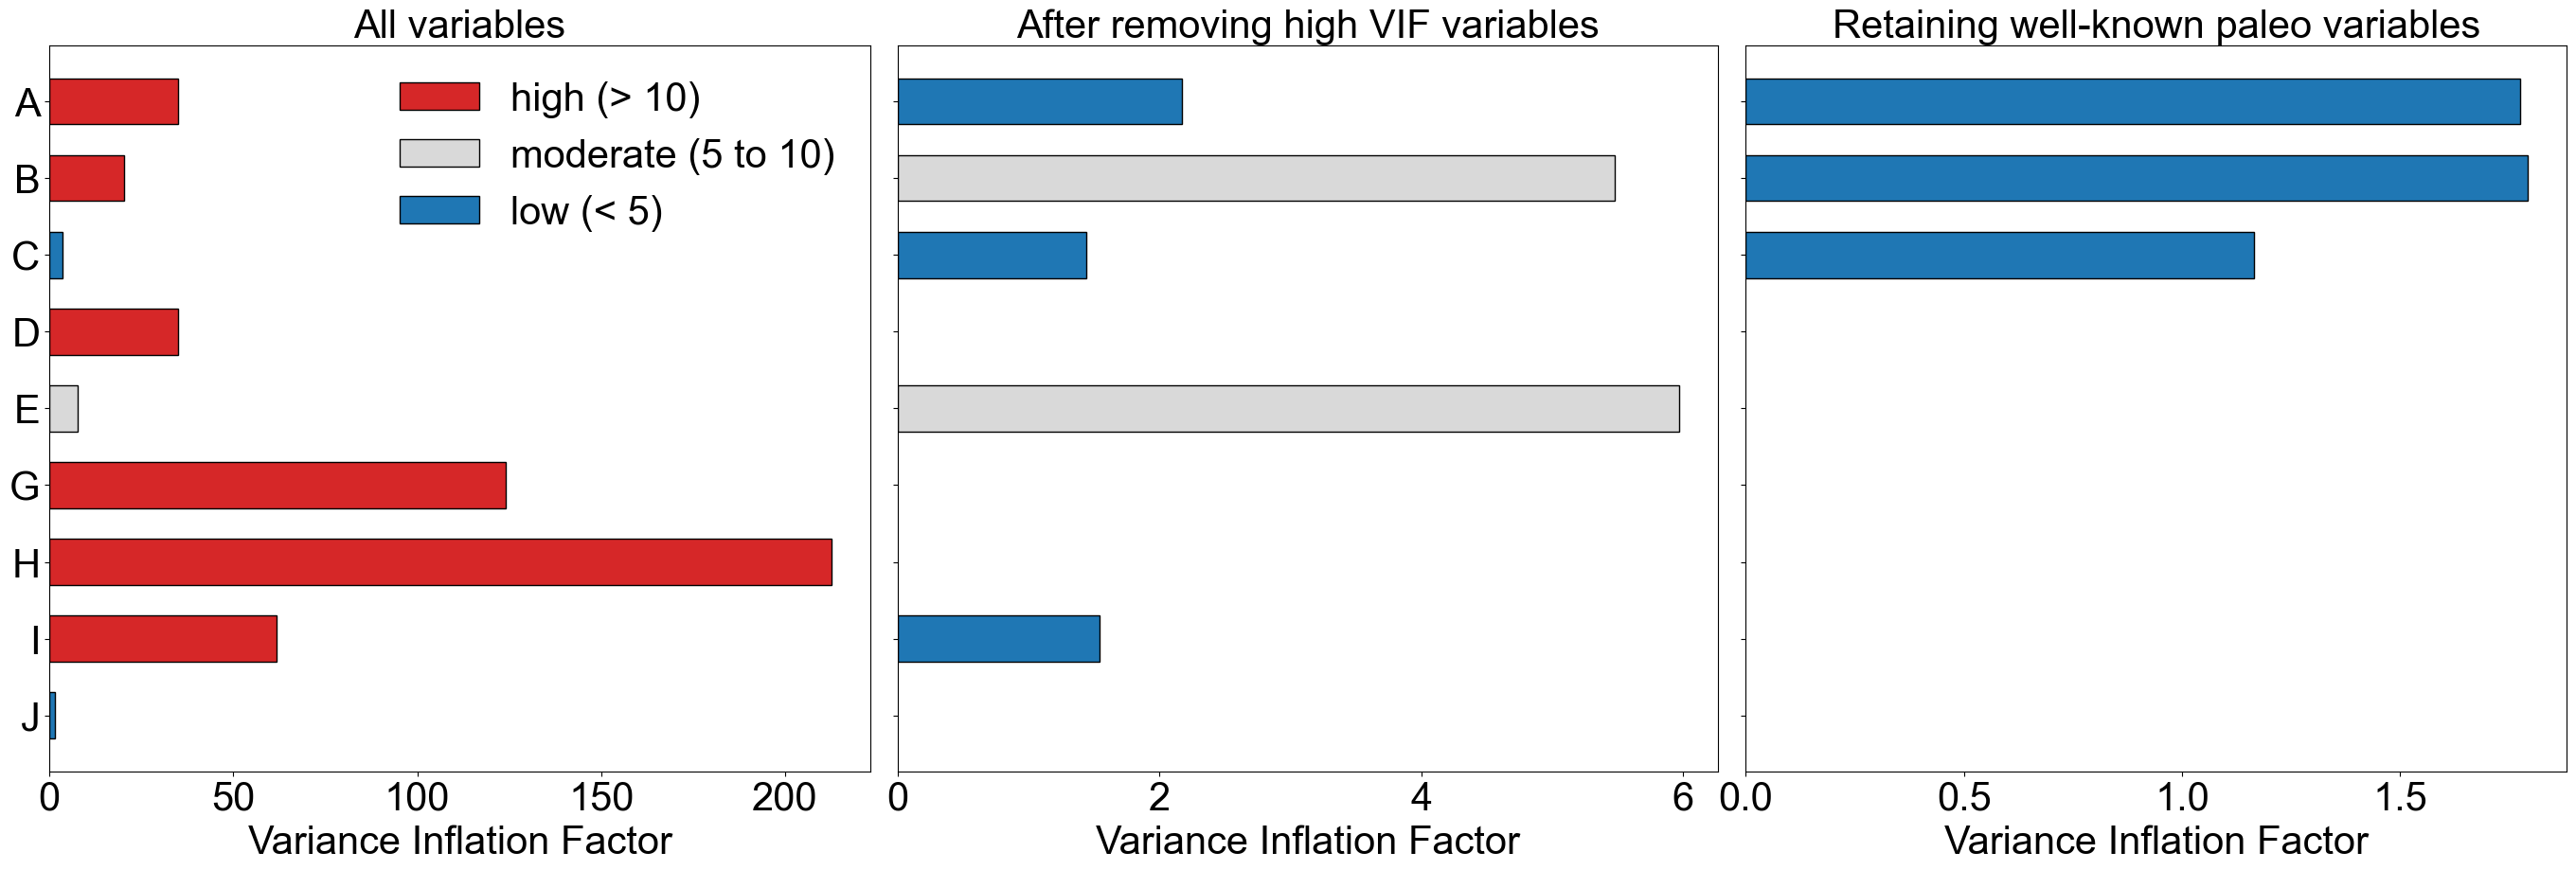

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Color definitions
blue = plt.cm.tab10(0)
gray = plt.cm.tab20c(20)
red = plt.cm.tab10(3)

plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 30

# Your DataFrame df_sub and initial features
# df_sub = pd.read_csv('your_data.csv')  # Ensure you load your DataFrame appropriately
X = df_sub[['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth',
            'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg']]

# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Iteratively remove features with the highest VIF, except u10_ann_avg for the second plot
def remove_high_vif_features(X, threshold=10, final_removal=False):
    while True:
        vif = calculate_vif(X)
        max_vif = vif['VIF'].max()
        if max_vif > threshold:
            max_vif_feature = vif.loc[vif['VIF'].idxmax(), 'variables']
            if final_removal or max_vif_feature != 'u10_ann_avg':
                print(f'Removing {max_vif_feature} with VIF={max_vif}')
                X = X.drop(columns=[max_vif_feature])
            else:
                break
        else:
            break
    if final_removal:
        if 'u10_ann_avg' in X.columns:
            print('Removing u10_ann_avg by request')
            X = X.drop(columns=['u10_ann_avg'])
        if 'log_depth' in X.columns:
            print('Removing log_depth by request')
            X = X.drop(columns=['log_depth'])
    return X, calculate_vif(X)

# Apply the function
X_reduced, final_vif = remove_high_vif_features(X)

# Remove specific variables with the highest VIF for the second plot
X_intermediate = X.drop(columns=['rh_ann_avg', 'ssr_ann_avg', 'log_lake_area', 'tcc_ann_avg'])

# Function to create a VIF bar graph
def create_vif_bar_graph(ax, X, categories, add_legend=False):
    # Create a DataFrame to store the VIF results
    vif_data = pd.DataFrame()
    vif_data["Variable"] = categories  # Use categories as y-axis labels
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    # Define colors based on VIF thresholds
    colors = [red if vif >= 10 else blue if vif < 5 else gray for vif in vif_data["VIF"]]

    # Create a bar graph with custom y-axis labels and conditional coloring
    ax.barh(vif_data["Variable"], vif_data["VIF"], color=colors, edgecolor='k', height=0.6)  # Add edgecolor='k'
    ax.set_xlabel('Variance Inflation Factor', labelpad=6)
    ax.invert_yaxis()  # Invert the y-axis to display the highest VIF at the top

    if add_legend:
        # Add a legend for the colors to the first subplot only
        legend_labels = ['high (> 10)', 'moderate (5 to 10)', 'low (< 5)']
        legend_colors = [red, gray, blue]
        legend_handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in legend_colors]
        ax.legend(legend_handles, legend_labels, loc='upper right', frameon=False)

# Create a single figure with three horizontally stacked subplots
fig, axs = plt.subplots(1, 3, figsize=(27, 9), sharey=True)  # Set sharex=True for a common y-axis

# First plot: All initial variables
categories1 = ['A', 'B', 'C', 'D', 'E', 'G', 'H', 'I', 'J']
create_vif_bar_graph(axs[0], X, categories1, add_legend=True)

# Second plot: After removing variables with high VIF except u10_ann_avg
categories2 = ['A', 'B', 'C', 'E', 'I']
create_vif_bar_graph(axs[1], X_intermediate, categories2, add_legend=False)

# Third plot: Final variables after removing 'u10_ann_avg' and 'log_depth'
X_final, final_vif_final = remove_high_vif_features(X_intermediate, final_removal=True)
categories3 = ['A', 'B', 'C']
create_vif_bar_graph(axs[2], X_final, categories3, add_legend=False)

# Set titles for subplots
axs[0].set_title('All variables', fontsize=30)
axs[1].set_title('After removing high VIF variables', fontsize=30)
axs[2].set_title('Retaining well-known paleo variables', fontsize=30)

# Set titles and font sizes for subplots
for ax in axs:
    ax.tick_params(axis='x', labelsize=30)  # Set x-axis tick label font size
    ax.tick_params(axis='y', labelsize=30)  # Set y-axis tick label font size

# Iterate through the legend patches and set their edgecolor to 'black'
for patch in axs[0].legend_.get_patches():
    patch.set_edgecolor('black')
    
# Adjust the spacing between subplots
plt.tight_layout(pad=0)

# Save the single figure as a PNG file
# plt.savefig('fig3cde_080726.png', dpi=300)

# Display the single figure with three horizontally stacked subplots
plt.show()


Iteration 0: Removing rh_ann_avg with VIF=212.58059363076723
Iteration 1: Removing ssr_ann_avg with VIF=61.099464135786384
Iteration 2: Removing log_lake_area with VIF=27.899289506539954
Iteration 3: Removing tcc_ann_avg with VIF=22.382208533904432
Iteration 4: Removing log_depth with VIF=5.9725993830517785


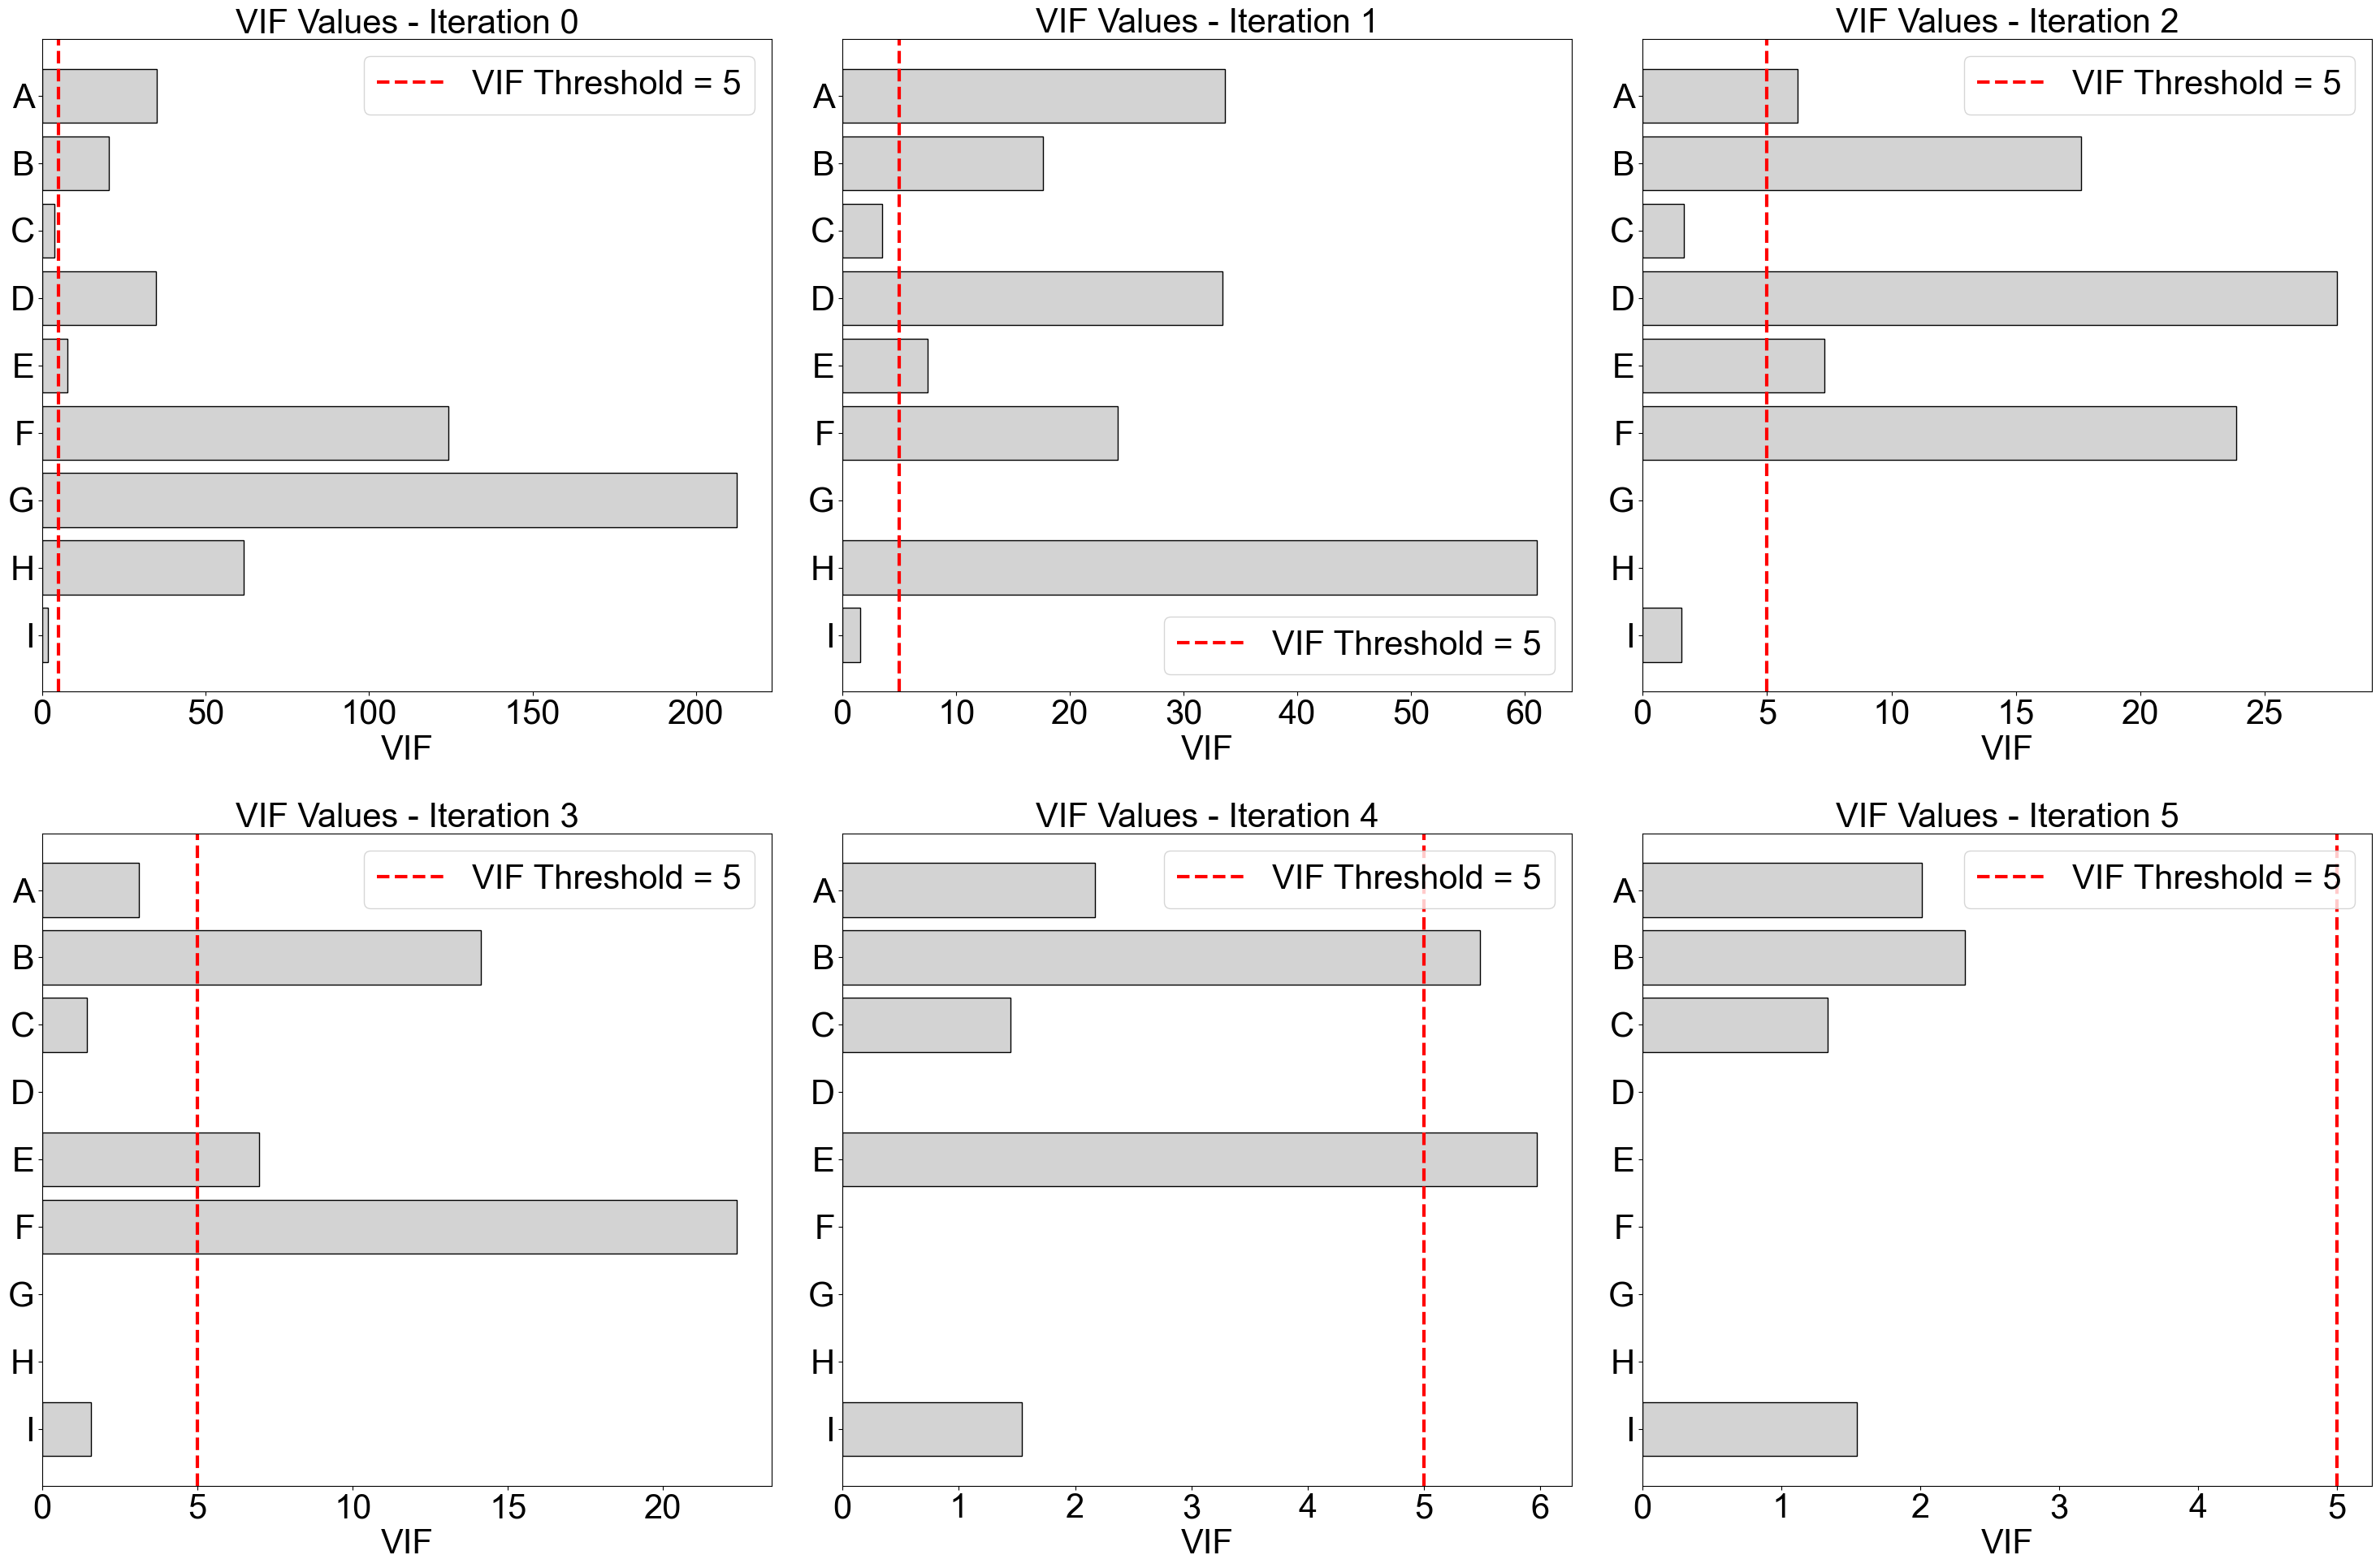

Final features:
 Index(['lswt_ao_avg', 'abs_lat', 'elevation_km', 'u10_ann_avg'], dtype='object')
Final VIFs:
       variables       VIF
0   lswt_ao_avg  2.007449
1       abs_lat  2.318227
2  elevation_km  1.330512
3   u10_ann_avg  1.543043


In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Your DataFrame df_sub and features
X = df_sub[['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth', 
            'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg']]

# Create a mapping of variables to labels 'A' to 'J'
variable_labels = {var: label for var, label in zip(X.columns, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])}

# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Function to iteratively remove features with the highest VIF and plot at each step
def remove_high_vif_and_plot(X, threshold=5):
    vifs_history = []
    iteration = 0
    while True:
        # Calculate VIF
        vif = calculate_vif(X)
        vifs_history.append((vif, iteration))  # Store VIF values and iteration number
        
        max_vif = vif['VIF'].max()
        if max_vif > threshold:
            max_vif_feature = vif.loc[vif['VIF'].idxmax(), 'variables']
            print(f'Iteration {iteration}: Removing {max_vif_feature} with VIF={max_vif}')
            X = X.drop(columns=[max_vif_feature])
            iteration += 1
        else:
            break

    # Plot all VIFs
    plot_vif_iterations(vifs_history)

    return X, vif

# Function to plot VIF values in a 3x2 grid of subplots and preserve variable order
def plot_vif_iterations(vifs_history):
    n_iterations = len(vifs_history)
    n_plots = min(n_iterations, 6)  # Limit to 6 plots per figure (3x2 grid)

    # Set global font size for everything
    plt.rcParams.update({'font.size': 30})

    fig, axes = plt.subplots(2, 3, figsize=(30, 20))  # Create a 3x2 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes

    # Get the original order of variables from the first iteration
    original_order = vifs_history[0][0]['variables'].tolist()

    for i, (vif, iteration) in enumerate(vifs_history):
        if i < len(axes):  # Only plot within available axes
            ax = axes[i]
            
            # Sort the VIF values according to the original variable order
            vif = vif.set_index('variables').reindex(original_order).reset_index()

            # Map variable names to labels 'A' to 'J'
            vif['labels'] = vif['variables'].map(variable_labels)

            # Plot horizontal bar plot with white bars and black outlines
            ax.barh(vif['labels'], vif['VIF'], facecolor='#D3D3D3', edgecolor = 'k', linewidth=1)
            ax.axvline(x=5, color='r', linestyle='--', linewidth=3, label='VIF Threshold = 5')
            ax.set_title(f'VIF Values - Iteration {iteration}', fontsize=30)
            ax.set_xlabel('VIF', fontsize=30)
            ax.legend(fontsize=30)
            
            # Reverse the y-axis order (J at the top, A at the bottom)
            ax.invert_yaxis()

            # Set the tick label size
            ax.tick_params(axis='both', which='major', labelsize=30)

    # Hide unused subplots if iterations are fewer than 6
    for j in range(len(vifs_history), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    
    plt.savefig('vif_revised.png', dpi = 300, bbox_inches = 'tight')
    plt.show()

# Apply the function
X_reduced, final_vif = remove_high_vif_and_plot(X)

# Print the final features and VIFs
print("Final features:\n", X_reduced.columns)
print("Final VIFs:\n", final_vif)


Iteration 0: Removing rh_ann_avg with VIF=212.58059363076723
Iteration 1: Removing ssr_ann_avg with VIF=61.099464135786384
Iteration 2: Removing log_lake_area with VIF=27.899289506539954
Iteration 3: Removing tcc_ann_avg with VIF=22.382208533904432
Iteration 4: Removing log_depth with VIF=5.9725993830517785


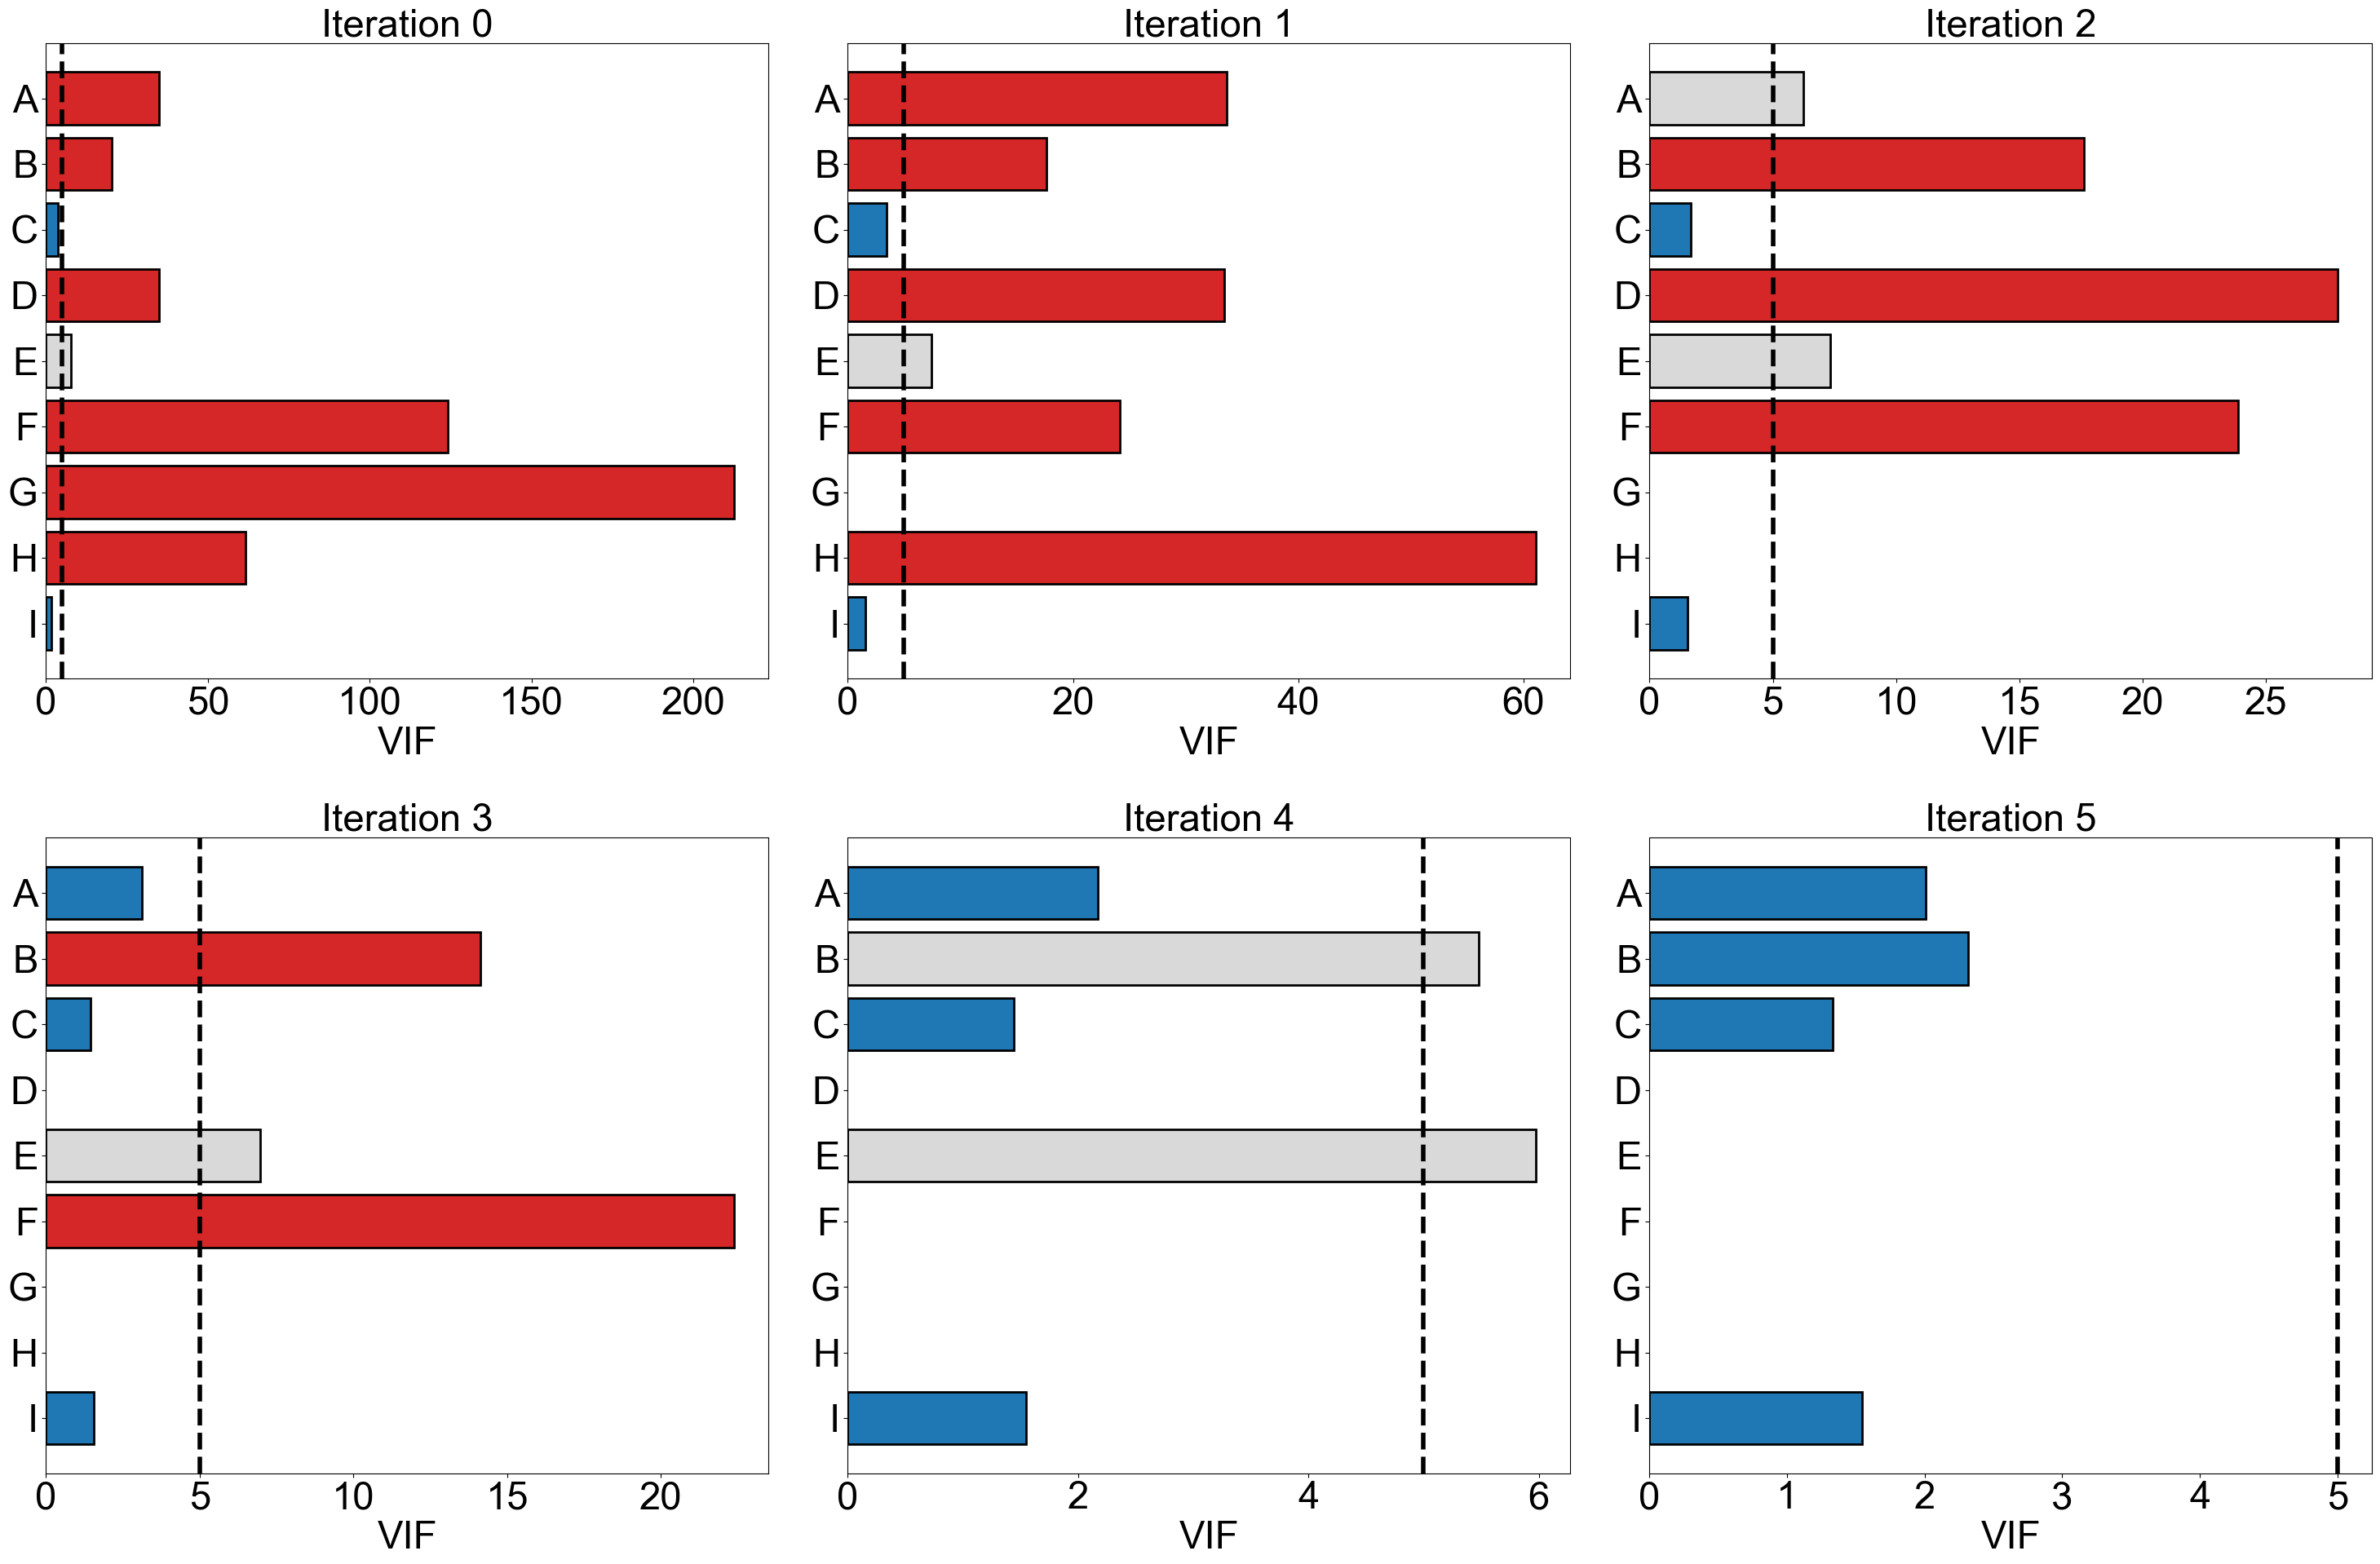

Final features:
 Index(['lswt_ao_avg', 'abs_lat', 'elevation_km', 'u10_ann_avg'], dtype='object')
Final VIFs:
       variables       VIF
0   lswt_ao_avg  2.007449
1       abs_lat  2.318227
2  elevation_km  1.330512
3   u10_ann_avg  1.543043


In [68]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Your DataFrame df_sub and features
X = df_sub[['lswt_ao_avg', 'abs_lat', 'elevation_km', 'log_lake_area', 'log_depth',
            'tcc_ann_avg', 'rh_ann_avg', 'ssr_ann_avg', 'u10_ann_avg']]


# Create a mapping of variables to labels 'A' to 'J'
variable_labels = {var: label for var, label in zip(X.columns, ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'])}

# Function to calculate VIF
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

# Function to iteratively remove features with the highest VIF and plot at each step
def remove_high_vif_and_plot(X, threshold=5):
    vifs_history = []
    iteration = 0
    while True:
        # Calculate VIF
        vif = calculate_vif(X)
        vifs_history.append((vif, iteration))  # Store VIF values and iteration number
        
        max_vif = vif['VIF'].max()
        if max_vif > threshold:
            max_vif_feature = vif.loc[vif['VIF'].idxmax(), 'variables']
            print(f'Iteration {iteration}: Removing {max_vif_feature} with VIF={max_vif}')
            X = X.drop(columns=[max_vif_feature])
            iteration += 1
        else:
            break

    # Plot all VIFs
    plot_vif_iterations(vifs_history)

    return X, vif

# Function to plot VIF values in a 3x2 grid of subplots and preserve variable order
def plot_vif_iterations(vifs_history):
    n_iterations = len(vifs_history)
    n_plots = min(n_iterations, 6)  # Limit to 6 plots per figure (3x2 grid)

    # Set global font size for everything
    plt.rcParams.update({'font.size': 34})

    fig, axes = plt.subplots(2, 3, figsize=(30, 20))  # Create a 3x2 grid of subplots
    axes = axes.flatten()  # Flatten the 2D array of axes

    # Get the original order of variables from the first iteration
    original_order = vifs_history[0][0]['variables'].tolist()


    for i, (vif, iteration) in enumerate(vifs_history):
        if i < len(axes):  # Only plot within available axes
            ax = axes[i]
            
            # Sort the VIF values according to the original variable order
            vif = vif.set_index('variables').reindex(original_order).reset_index()

            # Map variable names to labels 'A' to 'J'
            vif['labels'] = vif['variables'].map(variable_labels)

            # Assign colors based on VIF values
            # Color definitions
            blue = plt.cm.tab10(0)
            gray = plt.cm.tab20c(20)
            red = plt.cm.tab10(3)
            colors = [red if v > 10 else gray if 5 <= v <= 10 else blue for v in vif['VIF']]

            # Plot horizontal bar plot with color-coding
            ax.barh(vif['labels'], vif['VIF'], color=colors, edgecolor='black', linewidth=2)
            ax.axvline(x=5, color='k', linestyle='--', linewidth=4, label='VIF Threshold = 5')
            ax.set_title(f'Iteration {iteration}', fontsize=34)
            ax.set_xlabel('VIF', fontsize=34)
            
            # Reverse the y-axis order (J at the top, A at the bottom)
            ax.invert_yaxis()

            # Set the tick label size
            ax.tick_params(axis='both', which='major', labelsize=34)

    # Hide unused subplots if iterations are fewer than 6
    for j in range(len(vifs_history), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.savefig('vif_revised.png', dpi = 300, bbox_inches = 'tight')

    plt.show()

# Apply the function
X_reduced, final_vif = remove_high_vif_and_plot(X)

# Print the final features and VIFs
print("Final features:\n", X_reduced.columns)
print("Final VIFs:\n", final_vif)
